# 3 Period Korean Analysis

## [1. Moduel Import]

## [2. Data Load]

## [3. Preprocess]
#### 3-1) Data Cleaning
- 특수 문자 등 제거

#### 3-2) Tagging
- kkma를 이용하여 형태소 분석

#### 3-3) Remove Stopword
- 불용어 제거

#### 3-4) Tokenize
- LDA Modeling에 사용할 수 있도록 Token화

## [4. Analysis]
#### 4-1) Frequency
- 분석 1) 전체 Text에서의 Frequency (상위 30개)
- 분석 2) 각 POS('noun', 'verb', ...)별 분포와 비율
- 분석 3) 'noun'인 token들의 Frequncy (상위 30개)
- 분석 4) 'verb'인 token들의 Frequncy (상위 30개)
- 분석 5) 'adjective'인 token들의 Frequncy (상위 30개)
- 각 분석에 대해 StopWord 제거 이전과 이후에 대한 시각화를 모두 진행하였습니다.

#### 4-2) Topic Modeling (LDA)
- 토픽의 개수(NUM_TOPICS(= k))는 각 시기 당 할당된 기사의 수가 10개 이기 때문에 10으로 설정하였습니다.
- 실험적으로 최적의 k 값을 찾아나갈 예정입니다.
- Modeling에는 noun Token들만 추출하여 LDA 분석하였습니다.

#### 4-3) WordCloud
- 각 시기 별 Token들의 WordCloud
- noun token들만을 추출하여 WordCloud를 시각화하였습니다.

#### ~~4-4) Network web analysis~~
- 연관 관계 계산과정에서 실행시간이 오래 걸려서 먼저 완성할 수 있는 시각화 분석을 먼저 수행하였습니다.

## 1. Module Import

In [1]:
# self defined moduels
from myModules.TT.DataLoader import DataLoader
from myModules.TT.cleaning import cleaning
from myModules.TT.tagging import kkmaTagging
from myModules.TT.stopword import removeStopWord
from myModules.TT.tokenizing import tokenizing
from myModules.TT.mergeOverPeriod import merge
from myModules.TT.plotFrequency import calcTags, CountNLabelOverPOS, showCountNRate, tag2csv,plotOverallFrequency ,plotTagFrequency, plotPOSFrequency
from myModules.TT.ldaModeling import buildDTM, topicWords, visualizeLDA
from myModules.TT.plotWordCloud import plotWordCloud


# General Module
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

# Read File
import glob

# NLP
## tweepy version prob => install tweepy with version 3.9.0 
from gensim import models
from apyori import apriori


# Visualization
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Data Load

In [2]:
DATA_ROOT = './Data/3구간/'

PERIOD_1 = DATA_ROOT + '1시기/1시기_TT/'
PERIOD_2 = DATA_ROOT + '2시기/2시기_TT/'
PERIOD_3 = DATA_ROOT + '3시기/3시기_TT/'

RESULT_ROOT = './Result/3구간/'

RESULT_1 = RESULT_ROOT + '/1시기/TT/'
RESULT_2 = RESULT_ROOT + '/2시기/TT/'
RESULT_3 = RESULT_ROOT + '/3시기/TT/'

In [3]:
files_1 = glob.glob(PERIOD_1+'*.txt')
files_2 = glob.glob(PERIOD_2+'*.txt')
files_3 = glob.glob(PERIOD_3+'*.txt')

texts_1 = DataLoader(files_1)
texts_2 = DataLoader(files_2)
texts_3 = DataLoader(files_3)

## 3. Preprocess

### 3-1. Data Cleaning

In [4]:
cleaned_1 = cleaning(texts_1)
cleaned_2 = cleaning(texts_2)
cleaned_3 = cleaning(texts_3)

### 3-2. Taggging

In [5]:
tagged_1 = kkmaTagging(cleaned_1)
tagged_2 = kkmaTagging(cleaned_2)
tagged_3 = kkmaTagging(cleaned_3)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

### 3-3. Remove Stopword

#### Tag List 정의

In [6]:
tagList = [['noun', ['NN','NNS','NNP','NNPS'], ['NNG','NNB','NNP','NNM']], \
    ['pronoun', ['PRP','WP','PRP'], ['NP']],
    ['verb', ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'], ['VV', 'VXV', 'VCP']],
    ['adjective', ['JJ', 'JJR', 'JJS'], ['VA', 'VXA', 'VCN']],
    ['adverb', ['RB', 'RBR', 'RBS', 'WRB', 'EX', 'RP'], ['MAG']],
    ['prep&conj', ['TO', 'IN', 'CC'], ['MAC']],
    ['determiner', ['DT', 'PDT', 'WDT'], ['MDT', 'MDN']],
    ['interjection',['UH'], ['IC']],
    ['number', ['CD'], ['NR', 'ON']],
    ['foreignW', ['FW'],['OL']],
    ['modal',['MD'],[]],
    ['josa', [], ['JC', 'JK', 'JKC', 'JKG', 'JKI', 'JKM', 'JKO', 'JKQ', 'JKS', 'JX']],
    ['possesiveS', ['POS'], []],
    ['others',['LS'], ['EPH', 'EPT', 'EPP', 'EFN', 'EFQ', 'EFO', 'EFA', 'EFI', 'EFR', 'ECE', 'ECD', 'ECS', 'ETN', 'ETD', 'XPN', 'XPV', 'XSN', 'XSV', 'XSA', 'XR', 'UN', 'OH']]]

tagList = pd.DataFrame(tagList)
tagList.columns = ['POS', 'Eng_tag', 'Kor_tag']

#### Stopword 정의

Stopword는 다음과 같이 설정하였습니다.
- 감탄사 : 'IC'
- 조사 : 'JC', 'JK', 'JKC', 'JKG', 'JKI', 'JKM', 'JKO', 'JKQ', 'JKS', 'JX'
- 어미 : 'EPH', 'EPT', 'EPP', 'EFN', 'EFQ', 'EFO', 'EFA', 'EFI', 'EFR', 'ECE', 'ECD', 'ECS', 'ETN', 'ETD'
- 접두사 : 'XPN', 'XPV'
- 접미사 : 'XSN', 'XSV', 'XSA'
- 어근 : 'XR'
- 명사추정범주 : 'UN'
- 한자 : 'OH'
- 외국어 : 'OL'
- 숫자 : 'ON'
- [https://www.ranks.nl/stopwords/korean](https://www.ranks.nl/stopwords/korean) 에 나타나 있는 보편적인 한국어 불용어

In [7]:
stop_tag_list = ['IC', 'JC', 'JK', 'JKC', 'JKG', 'JKI', 'JKM', 'JKO', 'JKQ', 'JKS', 'JX', 'EPH', \
    'EPT', 'EPP', 'EFN', 'EFQ', 'EFO', 'EFA', 'EFI', 'EFR', 'ECE', 'ECD', 'ECS', 'ETN', 'ETD',
    'XSN', 'XSV', 'XSA', 'UN', 'OH', 'OL', 'ON', 'XPN', 'XPV', 'XR']

Kor_stopwords = ''

with open("./Data/Kor_stopwords.txt", 'r', encoding='utf-8') as f:
    stopword = f.read()
    Kor_stopwords = stopword

Kor_stopwords = Kor_stopwords.split('\n')

#### Stopword 제거

In [8]:
wo_stopword_1 = removeStopWord(tagged_1, stop_tag_list, Kor_stopwords)
wo_stopword_2 = removeStopWord(tagged_2, stop_tag_list, Kor_stopwords)
wo_stopword_3 = removeStopWord(tagged_3, stop_tag_list, Kor_stopwords)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

### 3-4. Tokenize

In [9]:
tokenized_1 = tokenizing(wo_stopword_1, tagList, 'all')
tokenized_2 = tokenizing(wo_stopword_2, tagList, 'all')
tokenized_3 = tokenizing(wo_stopword_3, tagList, 'all')

## 4. Analysis

### 4-1. Frequency

#### Period 1

In [10]:
countDict_1, classDict_1 = calcTags(merge(tagged_1), tagList)
wo_countDict_1, wo_classDict_1 = calcTags(merge(wo_stopword_1), tagList)

  0%|          | 0/94094 [00:00<?, ?it/s]

  0%|          | 0/28940 [00:00<?, ?it/s]

##### 분석 1) 전체 Text에서의 Frequency (상위 30개)

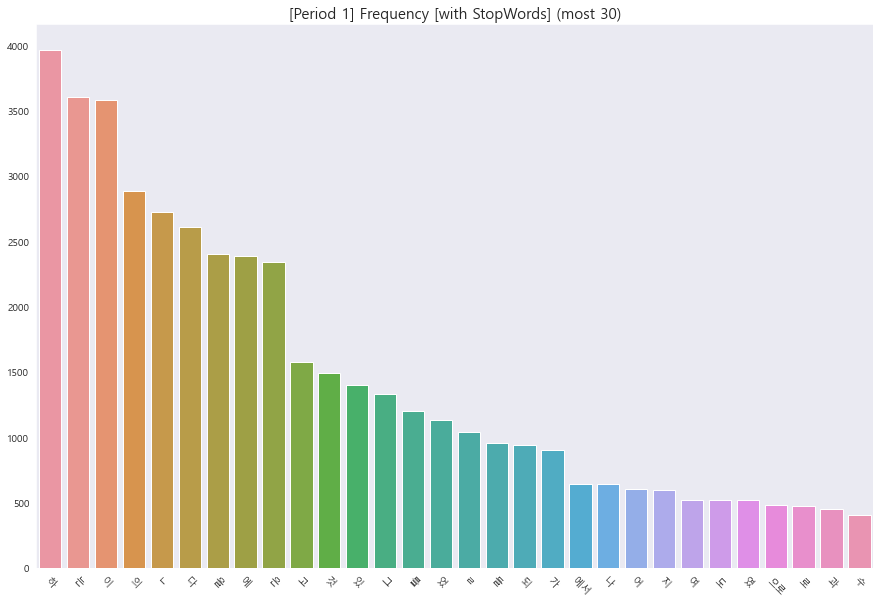

In [62]:
plotOverallFrequency(merge(tokenizing(tagged_1, tagList, pos='all')), filepath=RESULT_1, wo=False, period=1)

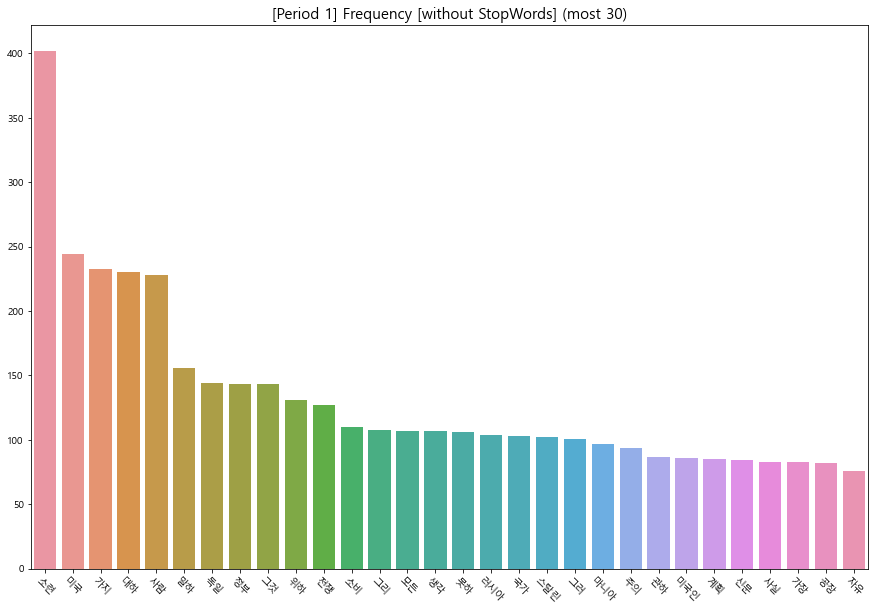

In [12]:
plotOverallFrequency(merge(tokenized_1), filepath=RESULT_1, wo=True, period=1)

##### 분석 2) 각 POS('noun', 'verb', ...)별 분포와 비율

In [13]:
showCountNRate(countDict_1, "with Stopwords")

[with Stopwords]
-------------------------
전체 토큰 수 | 94094개
[noun] 토큰 수 : 30894개 | 비율 : 32.83%
[pronoun] 토큰 수 : 2286개 | 비율 : 2.43%
[verb] 토큰 수 : 10419개 | 비율 : 11.07%
[adjective] 토큰 수 : 1596개 | 비율 : 1.7%
[adverb] 토큰 수 : 3110개 | 비율 : 3.31%
[prepnconj] 토큰 수 : 237개 | 비율 : 0.25%
[determiner] 토큰 수 : 1522개 | 비율 : 1.62%
[interjection] 토큰 수 : 5개 | 비율 : 0.01%
[number] 토큰 수 : 232개 | 비율 : 0.25%
[foreignW] 토큰 수 : 87개 | 비율 : 0.09%
[modal] 토큰 수 : 0개 | 비율 : 0.0%
[josa] 토큰 수 : 18744개 | 비율 : 19.92%
[possesiceS] 토큰 수 : 0개 | 비율 : 0.0%
[others] 토큰 수 : 24812개 | 비율 : 26.37%
-------------------------


In [14]:
showCountNRate(wo_countDict_1, "without Stopwords")

[without Stopwords]
-------------------------
전체 토큰 수 | 28940개
[noun] 토큰 수 : 23104개 | 비율 : 79.83%
[pronoun] 토큰 수 : 207개 | 비율 : 0.72%
[verb] 토큰 수 : 3258개 | 비율 : 11.26%
[adjective] 토큰 수 : 571개 | 비율 : 1.97%
[adverb] 토큰 수 : 1462개 | 비율 : 5.05%
[prepnconj] 토큰 수 : 0개 | 비율 : 0.0%
[determiner] 토큰 수 : 151개 | 비율 : 0.52%
[interjection] 토큰 수 : 0개 | 비율 : 0.0%
[number] 토큰 수 : 84개 | 비율 : 0.29%
[foreignW] 토큰 수 : 0개 | 비율 : 0.0%
[modal] 토큰 수 : 0개 | 비율 : 0.0%
[josa] 토큰 수 : 0개 | 비율 : 0.0%
[possesiceS] 토큰 수 : 0개 | 비율 : 0.0%
[others] 토큰 수 : 0개 | 비율 : 0.0%
-------------------------


In [15]:
tag2csv(countDict_1, classDict_1, tagList, RESULT_1 + "Frequency over POS-withstopword")
tag2csv(wo_countDict_1, wo_classDict_1, tagList, RESULT_1 + "Frequency over POS-withoutstopword")

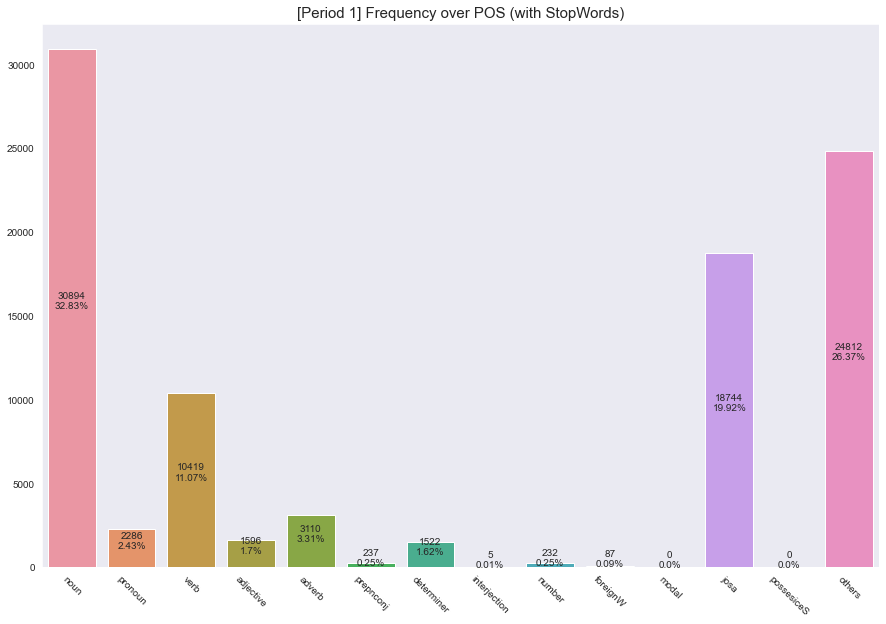

In [16]:
count, labels = CountNLabelOverPOS(countDict_1)

plotTagFrequency(count, labels, "[Period 1] Frequency over POS (with StopWords)", RESULT_1)

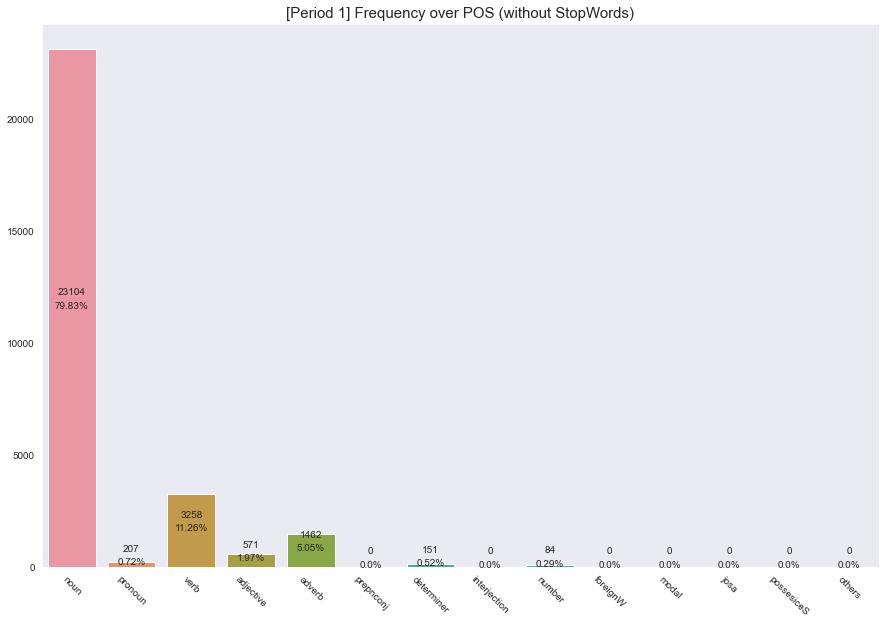

In [17]:
count, labels = CountNLabelOverPOS(wo_countDict_1)

plotTagFrequency(count, labels, "[Period 1] Frequency over POS (without StopWords)", RESULT_1)

##### 분석 3) 'noun'인 token들의 Frequncy (상위 30개)

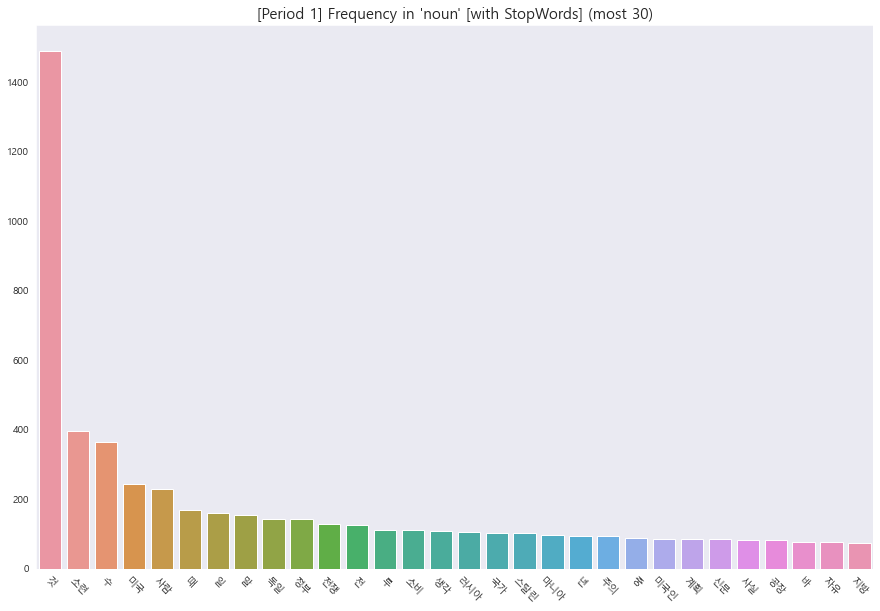

In [18]:
plotPOSFrequency(classDict_1, filepath=RESULT_1, pos='noun', wo=False, period=1)

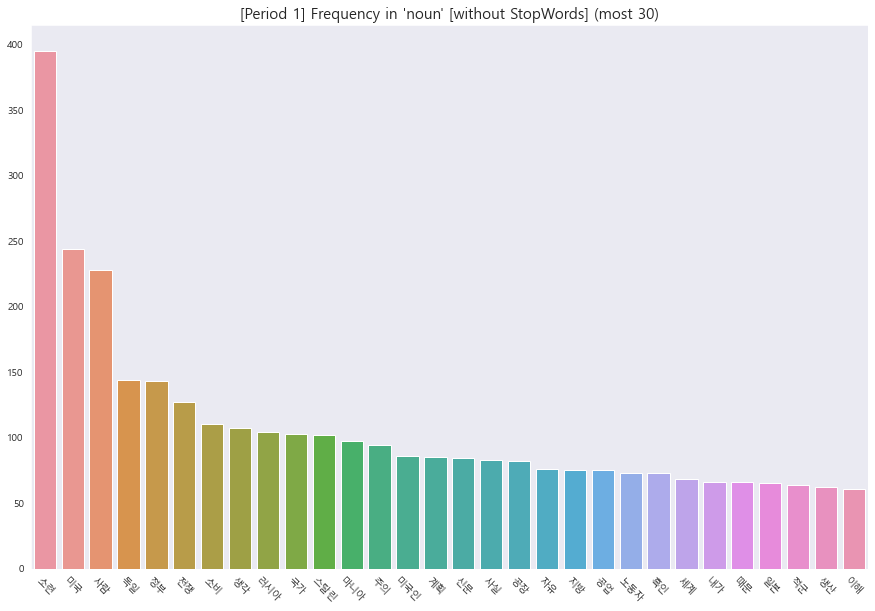

In [19]:
plotPOSFrequency(wo_classDict_1, filepath=RESULT_1, pos='noun', wo=True, period=1)

##### 분석 4) 'verb'인 token들의 Frequncy (상위 30개)

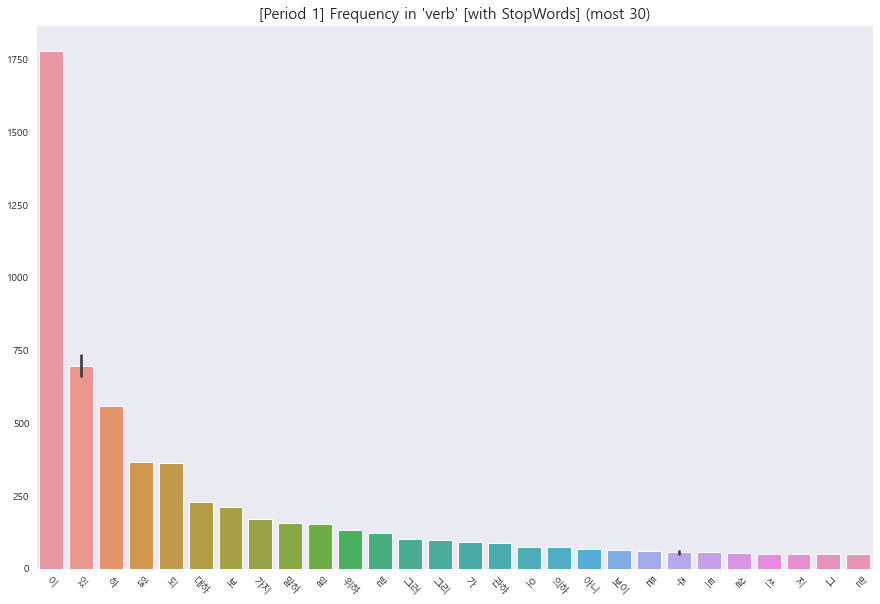

In [20]:
plotPOSFrequency(classDict_1, filepath=RESULT_1, pos='verb', wo=False, period=1)

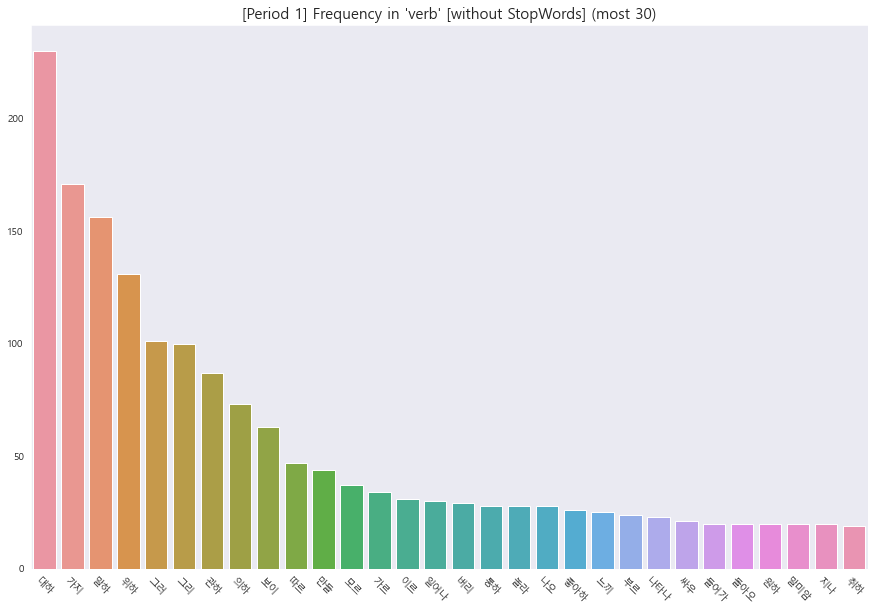

In [21]:
plotPOSFrequency(wo_classDict_1, filepath=RESULT_1, pos='verb', wo=True, period=1)

##### 분석 5) 'adjective'인 token들의 Frequncy (상위 30개)

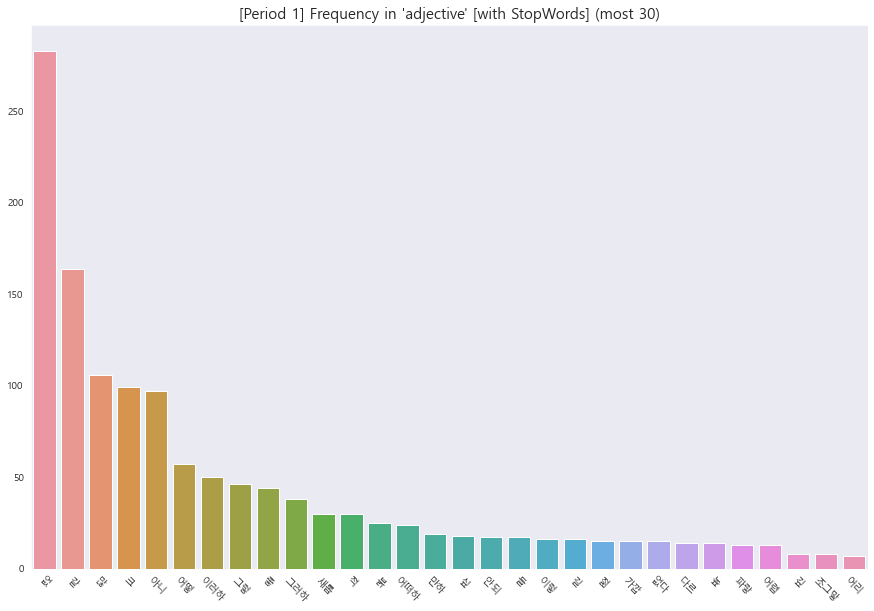

In [22]:
plotPOSFrequency(classDict_1, filepath=RESULT_1, pos='adjective', wo=False, period=1)

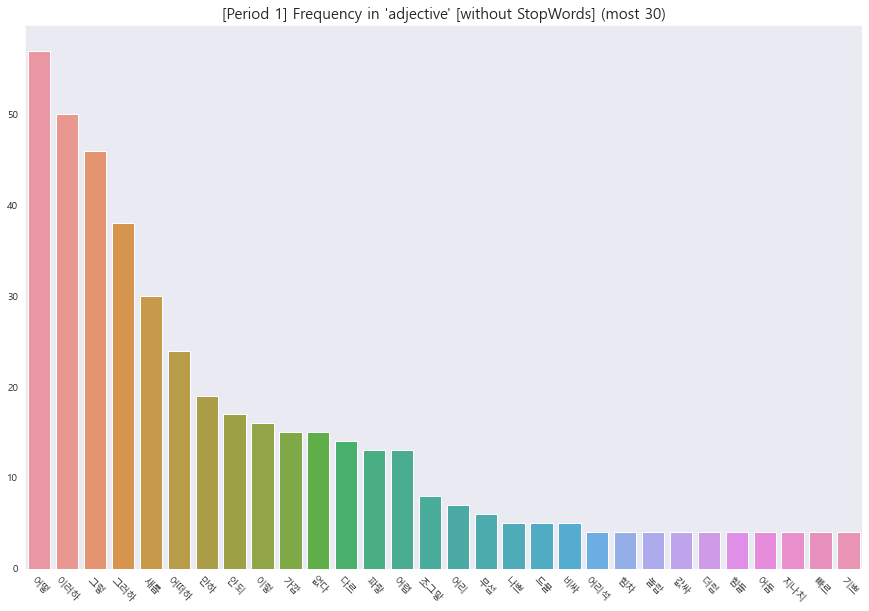

In [23]:
plotPOSFrequency(wo_classDict_1, filepath=RESULT_1, pos='adjective', wo=True, period=1)

#### Period 2

In [24]:
countDict_2, classDict_2 = calcTags(merge(tagged_2), tagList)
wo_countDict_2, wo_classDict_2 = calcTags(merge(wo_stopword_2), tagList)

  0%|          | 0/38067 [00:00<?, ?it/s]

  0%|          | 0/12503 [00:00<?, ?it/s]

##### 분석 1) 전체 Text에서의 Frequency (상위 30개)

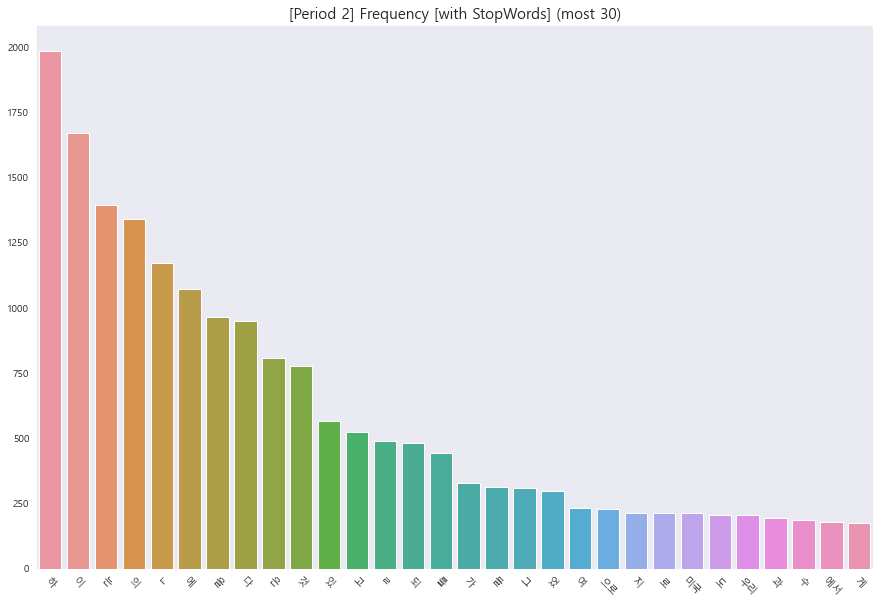

In [25]:
plotOverallFrequency(merge(tokenizing(tagged_2, tagList, pos='all')), filepath=RESULT_2, wo=False, period=2)

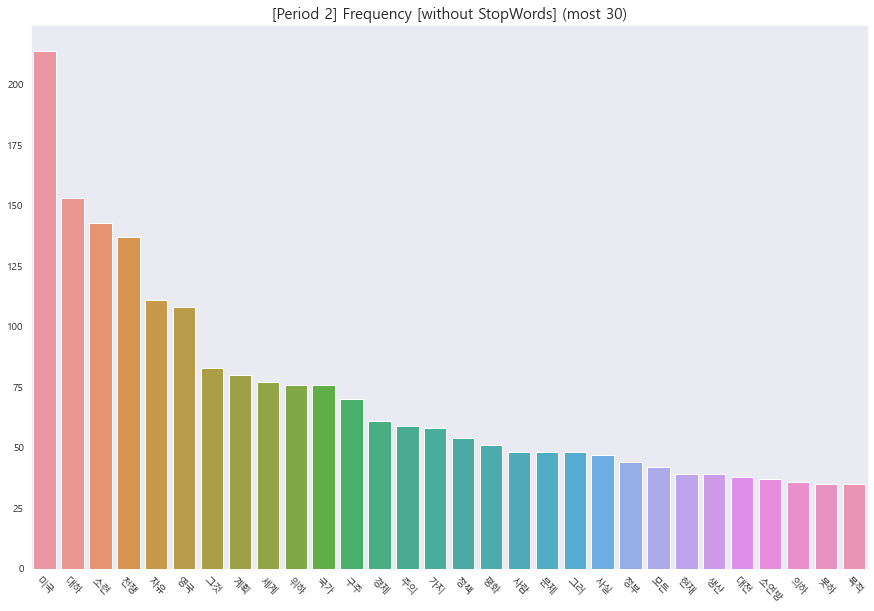

In [26]:
plotOverallFrequency(merge(tokenized_2), filepath=RESULT_2, wo=True, period=2)

##### 분석 2) 각 POS('noun', 'verb', ...)별 분포와 비율

In [27]:
showCountNRate(countDict_2, "with Stopwords")

[with Stopwords]
-------------------------
전체 토큰 수 | 38067개
[noun] 토큰 수 : 13543개 | 비율 : 35.58%
[pronoun] 토큰 수 : 634개 | 비율 : 1.67%
[verb] 토큰 수 : 3775개 | 비율 : 9.92%
[adjective] 토큰 수 : 512개 | 비율 : 1.34%
[adverb] 토큰 수 : 1070개 | 비율 : 2.81%
[prepnconj] 토큰 수 : 121개 | 비율 : 0.32%
[determiner] 토큰 수 : 520개 | 비율 : 1.37%
[interjection] 토큰 수 : 4개 | 비율 : 0.01%
[number] 토큰 수 : 157개 | 비율 : 0.41%
[foreignW] 토큰 수 : 152개 | 비율 : 0.4%
[modal] 토큰 수 : 0개 | 비율 : 0.0%
[josa] 토큰 수 : 7579개 | 비율 : 19.91%
[possesiceS] 토큰 수 : 0개 | 비율 : 0.0%
[others] 토큰 수 : 9942개 | 비율 : 26.12%
-------------------------


In [28]:
showCountNRate(wo_countDict_2, "without Stopwords")

[without Stopwords]
-------------------------
전체 토큰 수 | 12503개
[noun] 토큰 수 : 10507개 | 비율 : 84.04%
[pronoun] 토큰 수 : 99개 | 비율 : 0.79%
[verb] 토큰 수 : 1018개 | 비율 : 8.14%
[adjective] 토큰 수 : 188개 | 비율 : 1.5%
[adverb] 토큰 수 : 534개 | 비율 : 4.27%
[prepnconj] 토큰 수 : 0개 | 비율 : 0.0%
[determiner] 토큰 수 : 73개 | 비율 : 0.58%
[interjection] 토큰 수 : 0개 | 비율 : 0.0%
[number] 토큰 수 : 49개 | 비율 : 0.39%
[foreignW] 토큰 수 : 0개 | 비율 : 0.0%
[modal] 토큰 수 : 0개 | 비율 : 0.0%
[josa] 토큰 수 : 0개 | 비율 : 0.0%
[possesiceS] 토큰 수 : 0개 | 비율 : 0.0%
[others] 토큰 수 : 0개 | 비율 : 0.0%
-------------------------


In [29]:
tag2csv(countDict_2, classDict_2, tagList, RESULT_2 + "Frequency over POS-withstopword")
tag2csv(wo_countDict_2, wo_classDict_2, tagList, RESULT_2 + "Frequency over POS-withoutstopword")

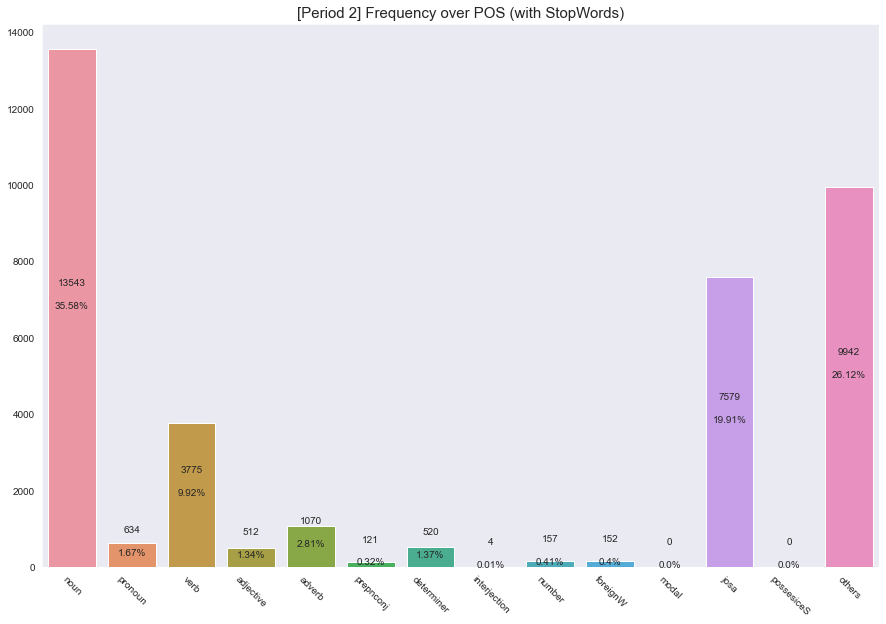

In [30]:
count, labels = CountNLabelOverPOS(countDict_2)

plotTagFrequency(count, labels, "[Period 2] Frequency over POS (with StopWords)", RESULT_2)

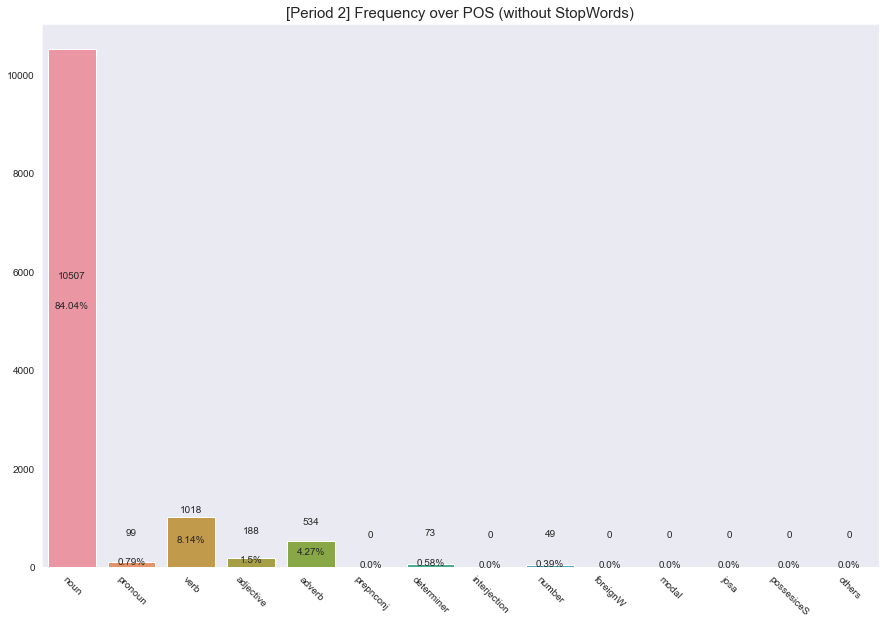

In [31]:
count, labels = CountNLabelOverPOS(wo_countDict_2)

plotTagFrequency(count, labels, "[Period 2] Frequency over POS (without StopWords)", RESULT_2)

##### 분석 3) 'noun'인 token들의 Frequncy (상위 30개)

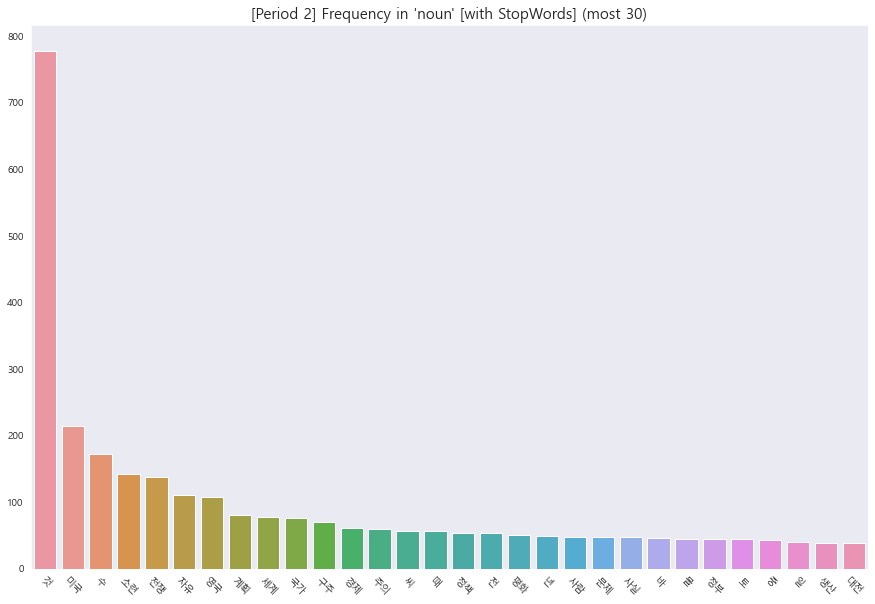

In [32]:
plotPOSFrequency(classDict_2, filepath=RESULT_2, pos='noun', wo=False, period=2)

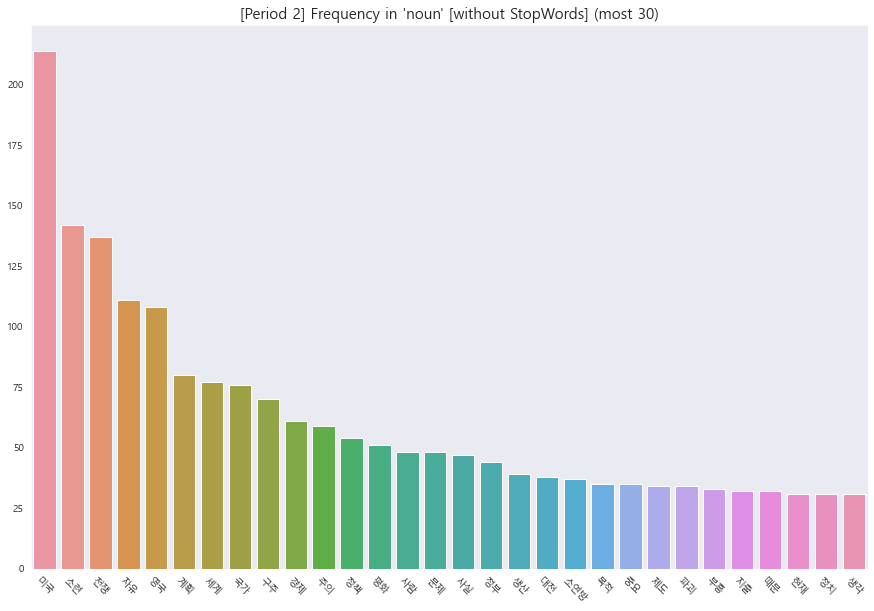

In [33]:
plotPOSFrequency(wo_classDict_2, filepath=RESULT_2, pos='noun', wo=True, period=2)

##### 분석 4) 'verb'인 token들의 Frequncy (상위 30개)

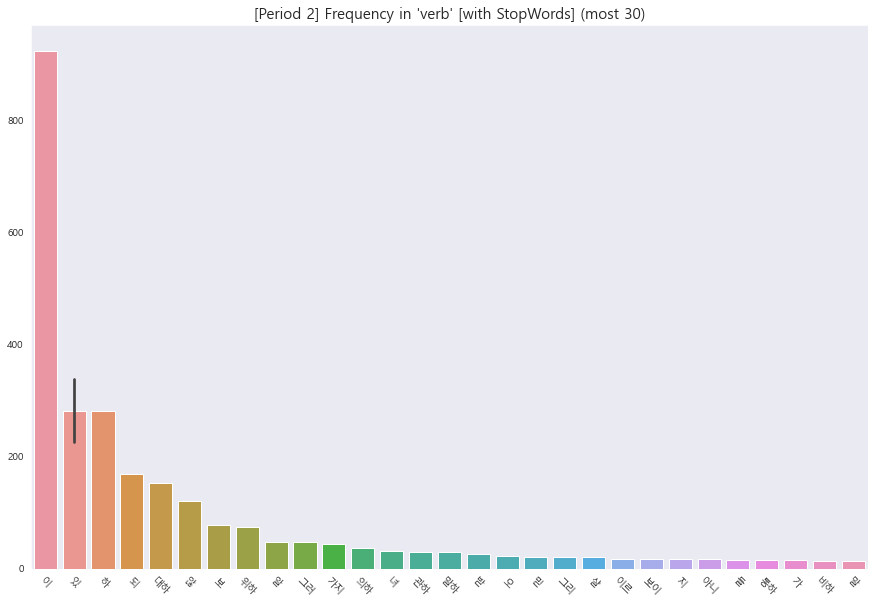

In [34]:
plotPOSFrequency(classDict_2, filepath=RESULT_2, pos='verb', wo=False, period=2)

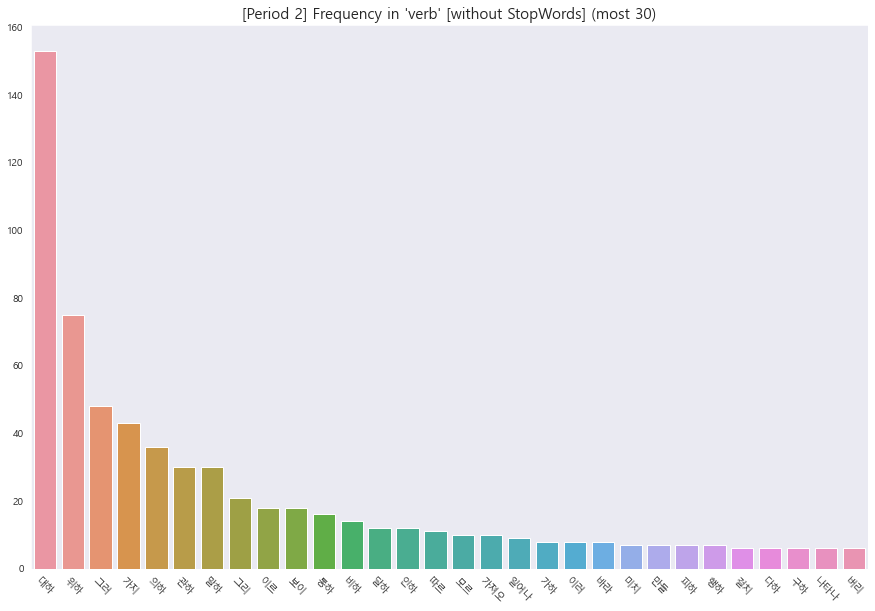

In [35]:
plotPOSFrequency(wo_classDict_2, filepath=RESULT_2, pos='verb', wo=True, period=2)

##### 분석 5) 'adjective'인 token들의 Frequncy (상위 30개)

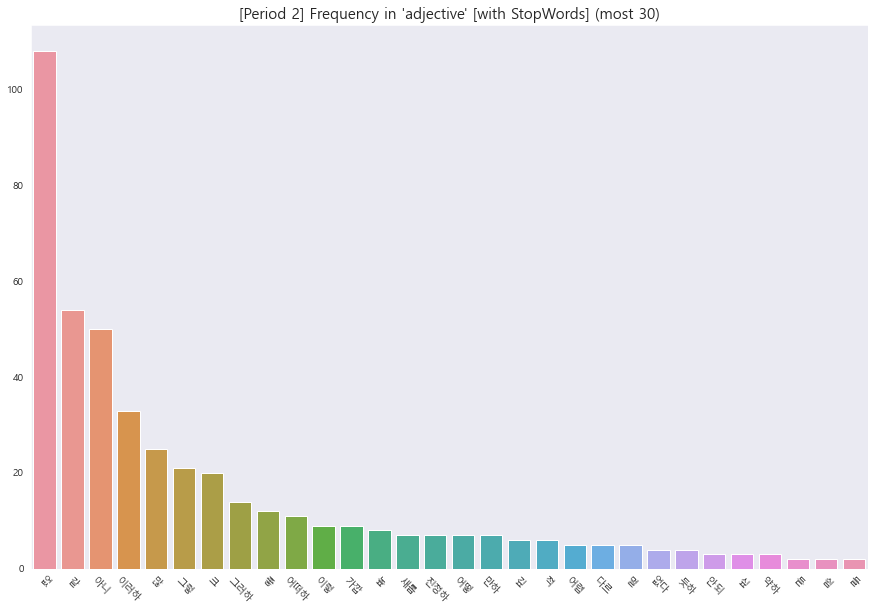

In [36]:
plotPOSFrequency(classDict_2, filepath=RESULT_2, pos='adjective', wo=False, period=2)

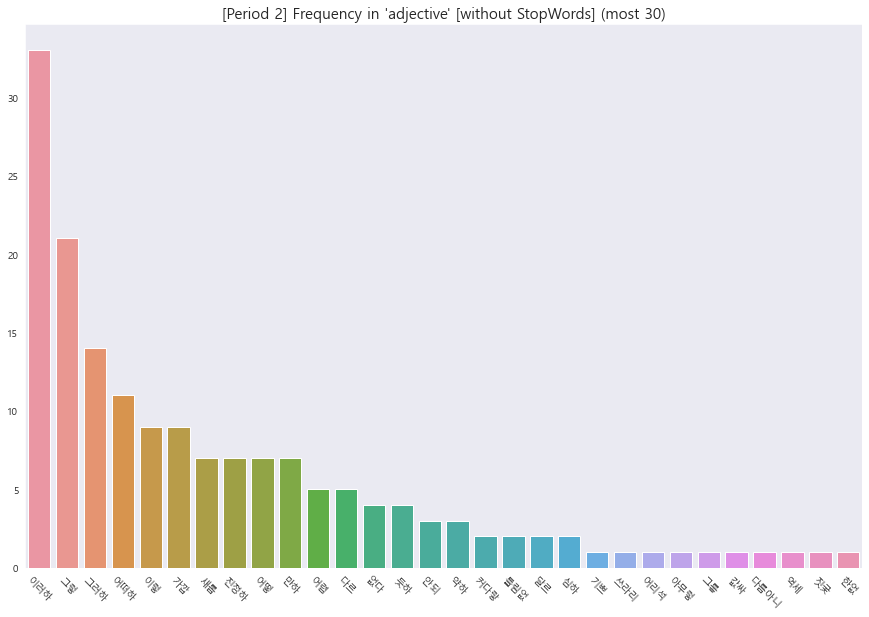

In [37]:
plotPOSFrequency(wo_classDict_2, filepath=RESULT_2, pos='adjective', wo=True, period=2)

#### Period 3

In [38]:
countDict_3, classDict_3 = calcTags(merge(tagged_3), tagList)
wo_countDict_3, wo_classDict_3 = calcTags(merge(wo_stopword_3), tagList)

  0%|          | 0/58736 [00:00<?, ?it/s]

  0%|          | 0/19034 [00:00<?, ?it/s]

##### 분석 1) 전체 Text에서의 Frequency (상위 30개)

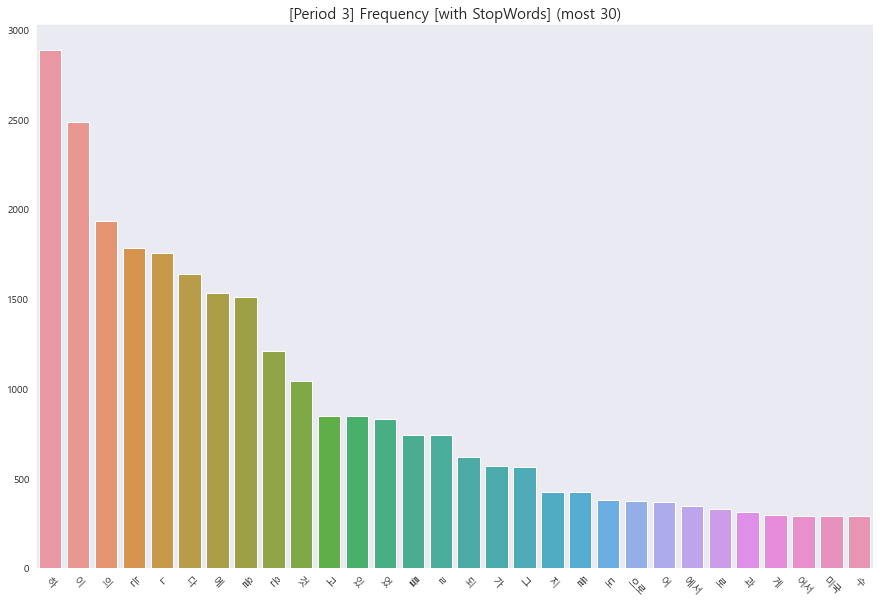

In [39]:
plotOverallFrequency(merge(tokenizing(tagged_3, tagList, pos='all')), filepath=RESULT_3, wo=False, period=3)

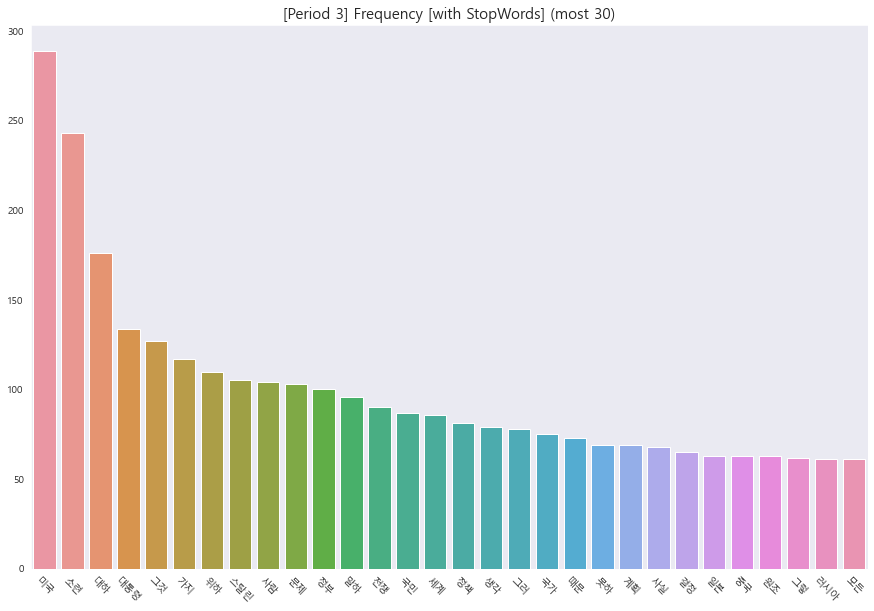

In [40]:
plotOverallFrequency(merge(tokenized_3), filepath=RESULT_3, wo=False, period=3)

##### 분석 2) 각 POS('noun', 'verb', ...)별 분포와 비율

In [41]:
showCountNRate(countDict_3, "with Stopwords")

[with Stopwords]
-------------------------
전체 토큰 수 | 58736개
[noun] 토큰 수 : 20275개 | 비율 : 34.52%
[pronoun] 토큰 수 : 1010개 | 비율 : 1.72%
[verb] 토큰 수 : 6339개 | 비율 : 10.79%
[adjective] 토큰 수 : 943개 | 비율 : 1.61%
[adverb] 토큰 수 : 1531개 | 비율 : 2.61%
[prepnconj] 토큰 수 : 161개 | 비율 : 0.27%
[determiner] 토큰 수 : 849개 | 비율 : 1.45%
[interjection] 토큰 수 : 6개 | 비율 : 0.01%
[number] 토큰 수 : 138개 | 비율 : 0.23%
[foreignW] 토큰 수 : 43개 | 비율 : 0.07%
[modal] 토큰 수 : 0개 | 비율 : 0.0%
[josa] 토큰 수 : 11720개 | 비율 : 19.95%
[possesiceS] 토큰 수 : 0개 | 비율 : 0.0%
[others] 토큰 수 : 15619개 | 비율 : 26.59%
-------------------------


In [42]:
showCountNRate(wo_countDict_3, "without Stopwords")

[without Stopwords]
-------------------------
전체 토큰 수 | 19034개
[noun] 토큰 수 : 15541개 | 비율 : 81.65%
[pronoun] 토큰 수 : 172개 | 비율 : 0.9%
[verb] 토큰 수 : 1867개 | 비율 : 9.81%
[adjective] 토큰 수 : 393개 | 비율 : 2.06%
[adverb] 토큰 수 : 868개 | 비율 : 4.56%
[prepnconj] 토큰 수 : 0개 | 비율 : 0.0%
[determiner] 토큰 수 : 95개 | 비율 : 0.5%
[interjection] 토큰 수 : 0개 | 비율 : 0.0%
[number] 토큰 수 : 31개 | 비율 : 0.16%
[foreignW] 토큰 수 : 0개 | 비율 : 0.0%
[modal] 토큰 수 : 0개 | 비율 : 0.0%
[josa] 토큰 수 : 0개 | 비율 : 0.0%
[possesiceS] 토큰 수 : 0개 | 비율 : 0.0%
[others] 토큰 수 : 0개 | 비율 : 0.0%
-------------------------


In [43]:
tag2csv(countDict_3, classDict_3, tagList, RESULT_3 + "Frequency over POS-withstopword")
tag2csv(wo_countDict_3, wo_classDict_3, tagList, RESULT_3 + "Frequency over POS-withoutstopword")

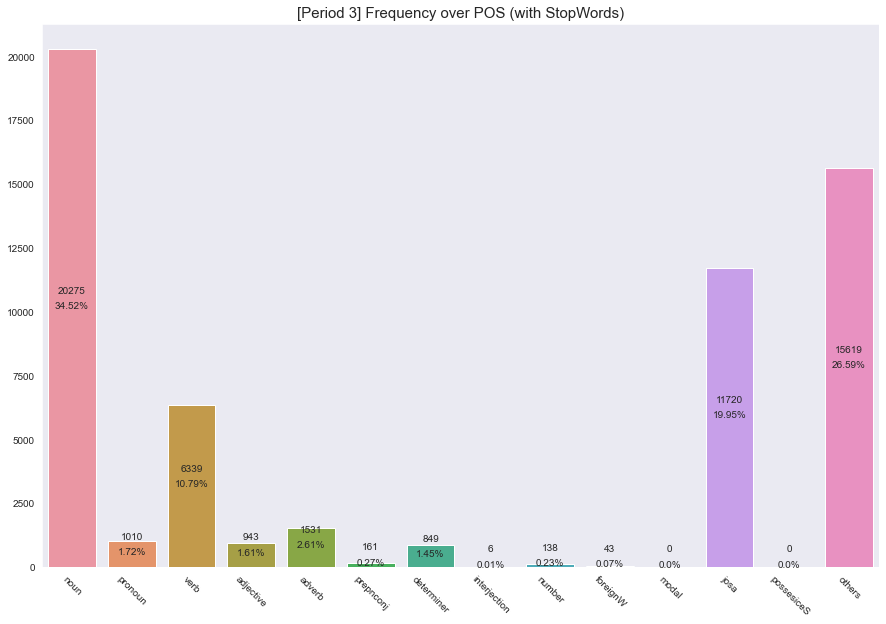

In [44]:
count, labels = CountNLabelOverPOS(countDict_3)

plotTagFrequency(count, labels, "[Period 3] Frequency over POS (with StopWords)", RESULT_3)

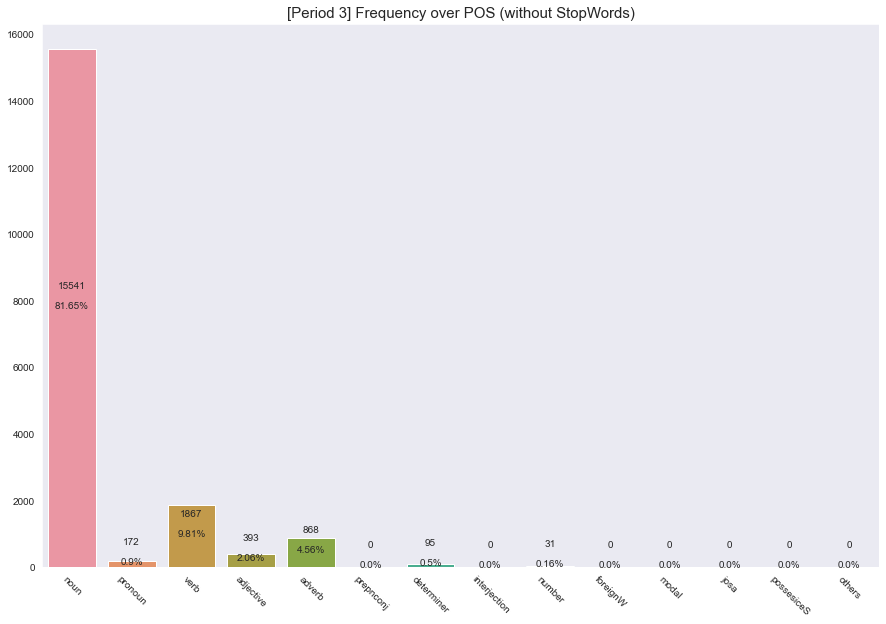

In [45]:
count, labels = CountNLabelOverPOS(wo_countDict_3)

plotTagFrequency(count, labels, "[Period 3] Frequency over POS (without StopWords)", RESULT_3)

##### 분석 3) 'noun'인 token들의 Frequncy (상위 30개)

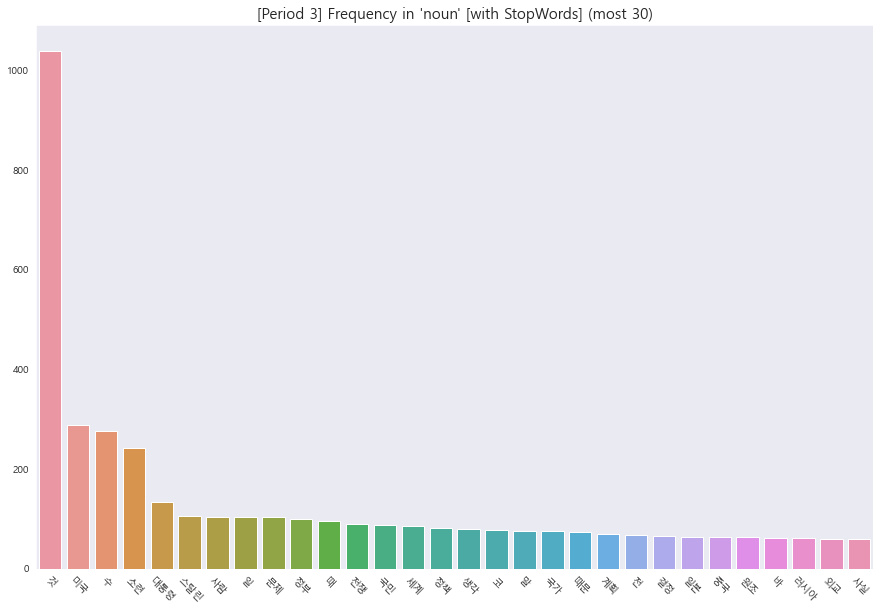

In [46]:
plotPOSFrequency(classDict_3, filepath=RESULT_3, pos='noun', wo=False, period=3)

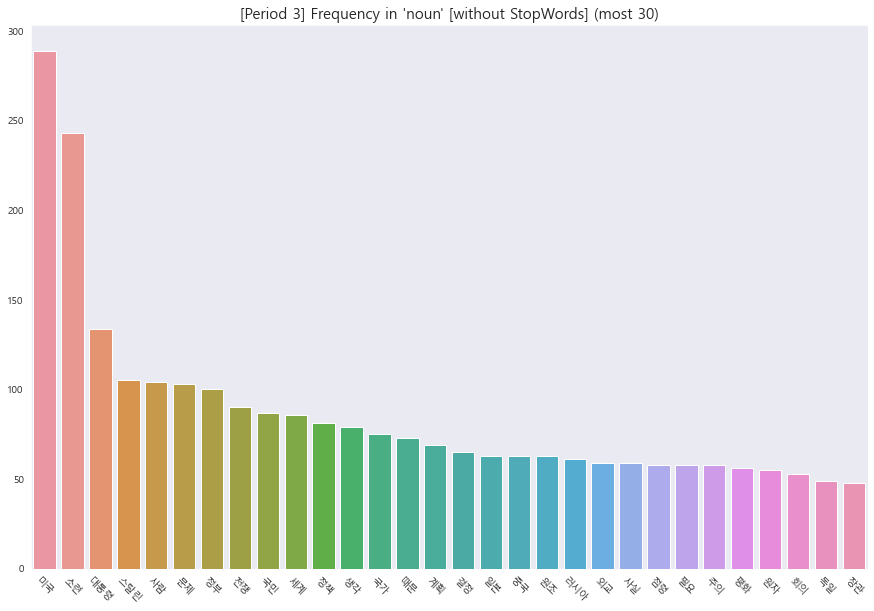

In [47]:
plotPOSFrequency(wo_classDict_3, filepath=RESULT_3, pos='noun', wo=True, period=3)

##### 분석 4) 'verb'인 token들의 Frequncy (상위 30개)

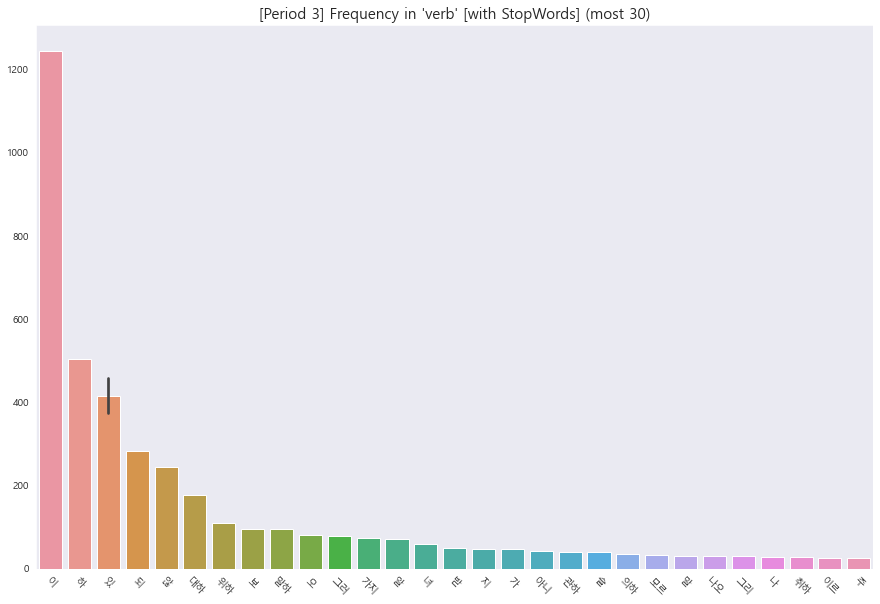

In [48]:
plotPOSFrequency(classDict_3, filepath=RESULT_3, pos='verb', wo=False, period=3)

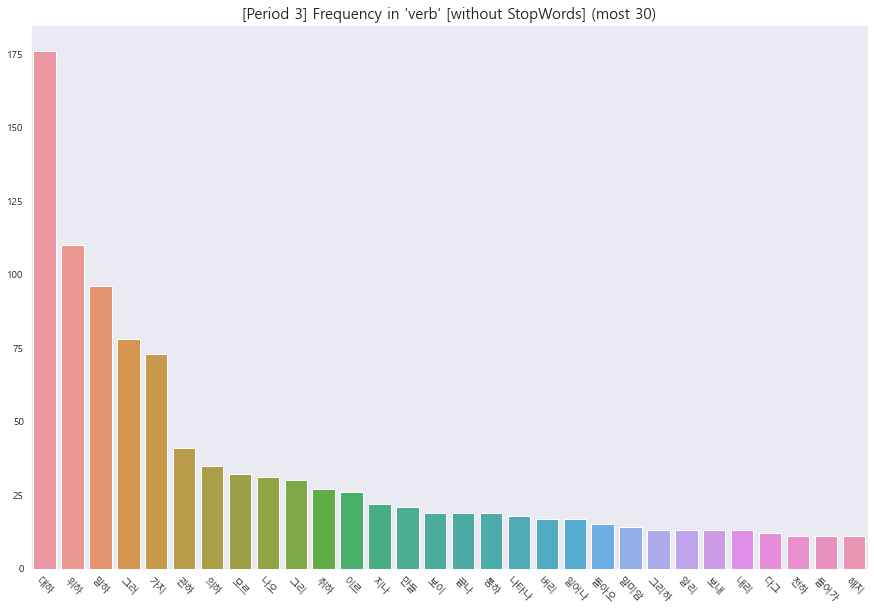

In [49]:
plotPOSFrequency(wo_classDict_3, filepath=RESULT_3, pos='verb', wo=True, period=3)

##### 분석 5) 'adjective'인 token들의 Frequncy (상위 30개)

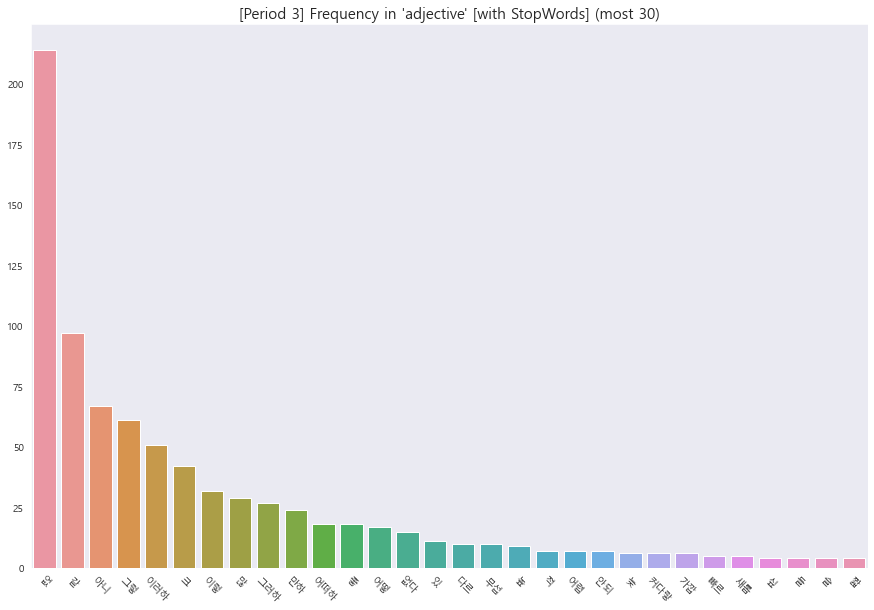

In [50]:
plotPOSFrequency(classDict_3, filepath=RESULT_3, pos='adjective', wo=False, period=3)

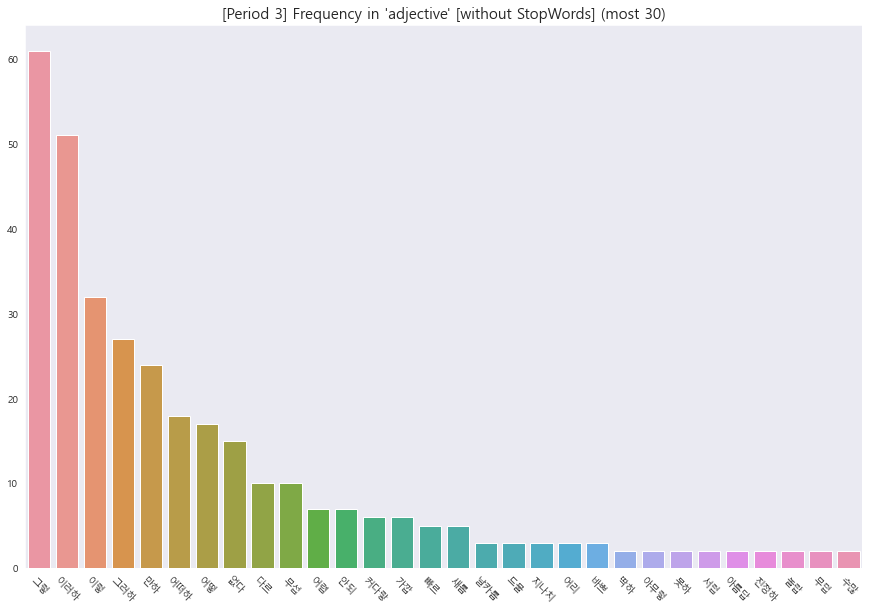

In [51]:
plotPOSFrequency(wo_classDict_3, filepath=RESULT_3, pos='adjective', wo=True, period=3)

### 4-2. Topic Modeling (LDA)

#### Hyper-parameter 정의

- 각 시기 당 article의 수가 10개 였기 때문에 k=10으로 설정하고 모델링하였습니다.
- 적절한 k 값은 실험적으로 찾아보겠습니다.

In [52]:
NUM_TOPICS = 10
NUM_TOPIC_WORDS = 30

#### LDA Modeling을 위해 Noun만 추출하여 Tokenizing

In [53]:
noun_token_1 = tokenizing(wo_stopword_1, tagList, pos='noun')
noun_token_2 = tokenizing(wo_stopword_2, tagList, pos='noun')
noun_token_3 = tokenizing(wo_stopword_3, tagList, pos='noun')

#### Period 1

In [54]:
Corp, Dict = buildDTM(noun_token_1)
model = models.ldamodel.LdaModel(Corp, num_topics = NUM_TOPICS, id2word=Dict)
topicdf = topicWords(model, NUM_TOPIC_WORDS)
data = visualizeLDA(model, Corp, Dict)

data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.005638  0.005045       1        1  42.384922
4      0.016983  0.000457       2        1  23.390737
7     -0.005106 -0.000933       3        1  14.251256
3     -0.007685 -0.002356       4        1  10.577813
6     -0.005586  0.006373       5        1   8.586258
0     -0.000773  0.006949       6        1   0.545290
1     -0.001544 -0.001141       7        1   0.212157
8      0.003145 -0.006351       8        1   0.042883
5      0.000069 -0.007916       9        1   0.004342
9     -0.005140 -0.000126      10        1   0.004342, topic_info=     Term        Freq       Total Category  logprob  loglift
703    소련  388.000000  388.000000  Default  30.0000  30.0000
442    미국  221.000000  221.000000  Default  29.0000  29.0000
592    사람  198.000000  198.000000  Default  28.0000  28.0000
346    독일  120.000000  120.000000  Default  27.0000  27.0000
1128   정부  121.000000  121.000000  Default  26.0000  26.0000
...   ...         ...         ...      ...      ...      ...
1194   주의    0.002668   93.148706  Topic10  -5.9295  -0.4159
4698   흑인    0.002257   70.224248  Topic10  -6.0968  -0.3007
168    국가    0.002342   95.937292  Topic10  -6.0599  -0.5759
261    내가    0.002082   63.575332  Topic10  -6.1775  -0.2820
683    세계    0.002010   62.442048  Topic10  -6.2129  -0.2994

[807 rows x 6 columns], token_table=      Topic      Freq Term
term                      
8         1  0.455666   가지
8         2  0.260380   가지
8         3  0.108492   가지
8         4  0.086793   가지
8         5  0.086793   가지
...     ...       ...  ...
1496      1  0.454342  히틀러
1496      2  0.259624  히틀러
1496      3  0.097359  히틀러
1496      4  0.097359  히틀러
1496      5  0.097359  히틀러

[1383 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 8, 4, 7, 1, 2, 9, 6, 10])

#### Period 2

In [55]:
Corp, Dict = buildDTM(noun_token_2)
model = models.ldamodel.LdaModel(Corp, num_topics = NUM_TOPICS, id2word=Dict)
topicdf = topicWords(model, NUM_TOPIC_WORDS)

data = visualizeLDA(model, Corp, Dict)

data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.023333  0.012837       1        1  44.587830
2      0.018487  0.002663       2        1  17.848762
7     -0.014779 -0.001478       3        1  13.595895
8      0.004751 -0.004924       4        1  10.294689
0     -0.010811 -0.010562       5        1   8.607114
6      0.009585  0.014591       6        1   5.027621
5      0.005019 -0.000535       7        1   0.009523
3      0.002398 -0.007075       8        1   0.009522
1      0.012766 -0.000302       9        1   0.009522
4     -0.004083 -0.005216      10        1   0.009522, topic_info=    Term        Freq       Total Category  logprob  loglift
225   미국  212.000000  212.000000  Default  30.0000  30.0000
532   전쟁  116.000000  116.000000  Default  29.0000  29.0000
350   소련  108.000000  108.000000  Default  28.0000  28.0000
428   영국  118.000000  118.000000  Default  27.0000  27.0000
506   자유   88.000000   88.000000  Default  26.0000  26.0000
..   ...         ...         ...      ...      ...      ...
576   주의    0.002855   49.583645  Topic10  -5.8591  -0.5030
343   세계    0.003049   65.931053  Topic10  -5.7935  -0.7223
222   문제    0.002553   37.822558  Topic10  -5.9711  -0.3442
964   정책    0.002548   54.192536  Topic10  -5.9731  -0.7058
48    경제    0.002477   59.213035  Topic10  -6.0012  -0.8226

[812 rows x 6 columns], token_table=      Topic      Freq Term
term                      
0         1  0.460935   가능
0         2  0.230468   가능
0         3  0.138281   가능
0         4  0.092187   가능
0         5  0.092187   가능
...     ...       ...  ...
749       2  0.198016   희랍
749       3  0.099008   희랍
749       4  0.148512   희랍
749       5  0.198016   희랍
749       6  0.049504   희랍

[1292 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 3, 8, 9, 1, 7, 6, 4, 2, 5])

#### Period 3

In [56]:
Corp, Dict = buildDTM(noun_token_3)
model = models.ldamodel.LdaModel(Corp, num_topics = NUM_TOPICS, id2word=Dict)
topicdf = topicWords(model, NUM_TOPIC_WORDS)

data = visualizeLDA(model, Corp, Dict)

data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.014207  0.012912       1        1  34.441823
4      0.026368 -0.001190       2        1  28.534914
3      0.003438  0.014933       3        1  15.079434
2     -0.003261 -0.009711       4        1  12.645847
0     -0.003360 -0.007073       5        1   7.219968
6     -0.005570 -0.000264       6        1   2.048348
5     -0.004780 -0.008918       7        1   0.008404
1      0.000352  0.005259       8        1   0.007087
9      0.004465  0.005260       9        1   0.007087
8     -0.003444 -0.011209      10        1   0.007087, topic_info=     Term        Freq       Total Category  logprob  loglift
217    미국  237.000000  237.000000  Default  30.0000  30.0000
312    소련  202.000000  202.000000  Default  29.0000  29.0000
152   대통령  114.000000  114.000000  Default  28.0000  28.0000
216    문제   78.000000   78.000000  Default  27.0000  27.0000
272    사람   91.000000   91.000000  Default  26.0000  26.0000
...   ...         ...         ...      ...      ...      ...
681    회의    0.002520   51.639875  Topic10  -6.0799  -0.3730
85     국민    0.002815   77.123258  Topic10  -5.9694  -0.6636
180   러시아    0.002436   52.837608  Topic10  -6.1138  -0.4298
1217   평화    0.002260   44.239349  Topic10  -6.1888  -0.3272
532    중국    0.002233   47.967197  Topic10  -6.2011  -0.4204

[807 rows x 6 columns], token_table=      Topic      Freq Term
term                      
5         1  0.336492   가지
5         2  0.275312   가지
5         3  0.152951   가지
5         4  0.122361   가지
5         5  0.061180   가지
...     ...       ...  ...
3295      2  0.478581  휴지통
3295      4  0.478581  휴지통
1265      1  0.547442  히틀러
1265      2  0.273721  히틀러
1265      5  0.273721  히틀러

[1333 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 5, 4, 3, 1, 7, 6, 2, 10, 9])

### 4-3. WordCloud

#### Period 1

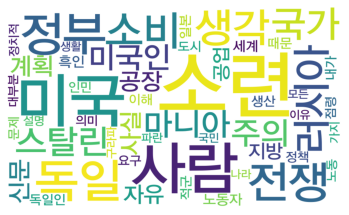

In [57]:
plotWordCloud(merge(noun_token_1), RESULT_1 + 'WordCloud')

#### Period 2

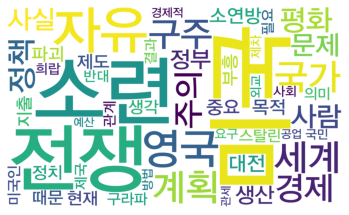

In [58]:
plotWordCloud(merge(noun_token_2), RESULT_2 + 'WordCloud')

#### Period 3

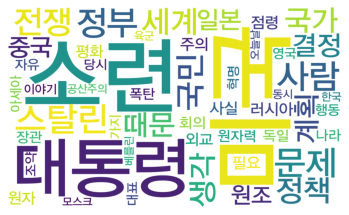

In [59]:
plotWordCloud(merge(noun_token_3), RESULT_3 + 'WordCloud')

### 4-4. Network web analysis

In [60]:
# result = (list(apriori(tokenized_1, min_support=0.01)))

In [61]:
# df = pd.DataFrame(result)
# df['length'] = df['items'].apply(lambda x: len(x))
# df = df[(df['length'] == 2) & \
#     (df['support'] >= 0.01)].sort_values(by='support', ascending=False)
# df.head(10)